# Demonstration of statistical clear sky fitting

6/24/2025

This notebook demontrates how to use the newly updated clear sky fitting method, based on smooth, periodic quantile estimation. The basic steps are:

- load data
- run pipeline
- estimate clear sky model

## Notebook setup and library imports

In [1]:
from solardatatools import DataHandler, plot_2d
from solardatatools.dataio import get_pvdaq_data

## Load data

We use NREL's PVDAQ API with a function from the Solar Data Tools DataIO module

In [2]:
data_frame = get_pvdaq_data(sysid=34, year=range(2011, 2015), api_key="DEMO_KEY")

[============================================================] 100.0% ...queries complete in 3.2 seconds       



## Run main pipeline

In [3]:
dh = DataHandler(data_frame)
dh.run_pipeline(power_col="ac_power")


            *********************************************
            * Solar Data Tools Data Onboarding Pipeline *
            *********************************************

            This pipeline runs a series of preprocessing, cleaning, and quality
            control tasks on stand-alone PV power or irradiance time series data.
            After the pipeline is run, the data may be plotted, filtered, or
            further analyzed.

            Authors: Bennet Meyers and Sara Miskovich, SLAC

            (Tip: if you have a mosek [https://www.mosek.com/] license and have it
            installed on your system, try setting solver='MOSEK' for a speedup)

            This material is based upon work supported by the U.S. Department
            of Energy's Office of Energy Efficiency and Renewable Energy (EERE)
            under the Solar Energy Technologies Office Award Number 38529.

            


task list: 100%|██████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]



total time: 9.67 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              2.18s
Cleaning                   0.11s
Filtering/Summarizing      7.38s
    Data quality           0.08s
    Clear day detect       0.16s
    Clipping detect        3.24s
    Capacity change detect 3.89s



## Fit clear sky model

The `nvals_dil` parameter controlls how many data points used each day in the model. The higher the number of values, the longer the fit time (and it scales linearly).

5-minute data has 288 data points per day, roughly 50\% of which are nighttime zeros, on average, and so the default is set to `nvals_dil=101`, to give you 100 data points between sunrise and sunset plus one "nighttime" value. 

This data example happens to have 15-minute data, or 96 data points per data. Setting `nvals_dil=31` avoids excessive upsampling of the data and reduces the fit time for the clear sky model by 1/3.

the `regularization` parameter controls the "stiffness" of the fit, with high values resulting in less "wiggly" fits. The defualt value is `0.1`, and we bumped it up to `1.0` for this example (simple data set with not a lot of variability or shade effects).

In [16]:
dh.fit_statistical_clear_sky_model(nvals_dil=31, regularization=1)

100%|█████████████████████████████████████████████| 1/1 [01:06<00:00, 66.79s/it]


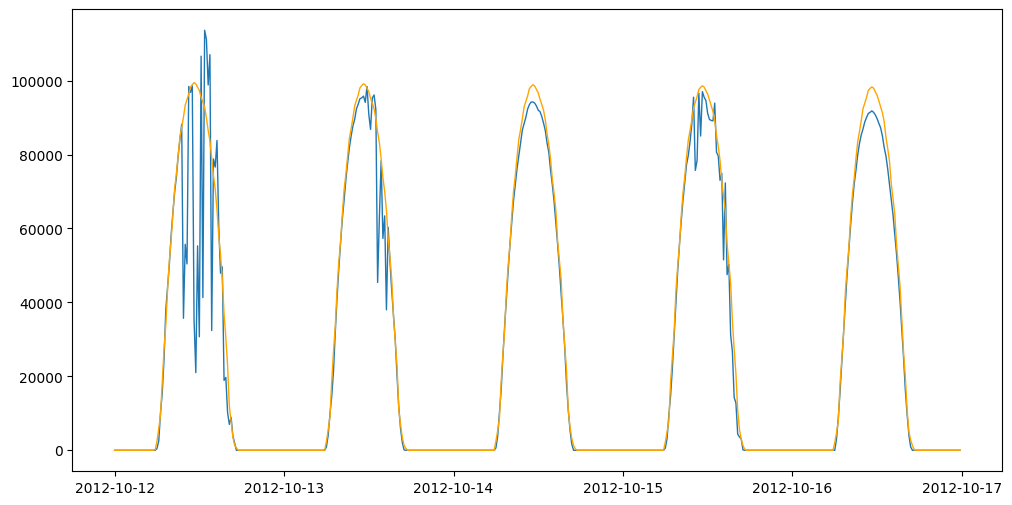

In [17]:
dh.plot_daily_signals(show_clear_model=True, start_day=650);

The estimated clear sky signal is available in the `self.scsf` attribute

In [18]:
dh.scsf

array([808.74757358, 808.74757358, 808.74757358, ...,   0.        ,
         0.        ,   0.        ], shape=(140256,))

The clear sky fitting module is a wrapper on the more general quantile estimation module. As seen below, estimating the clear sky model is the same as estimating the 0.9 quanile.

In [19]:
dh.quantile_object.quantiles_original

{np.float64(0.9): array([808.74757358, 808.74757358, 808.74757358, ...,   0.        ,
          0.        ,   0.        ], shape=(140256,))}

## Compare actual and estimated power heatmaps

measured power:

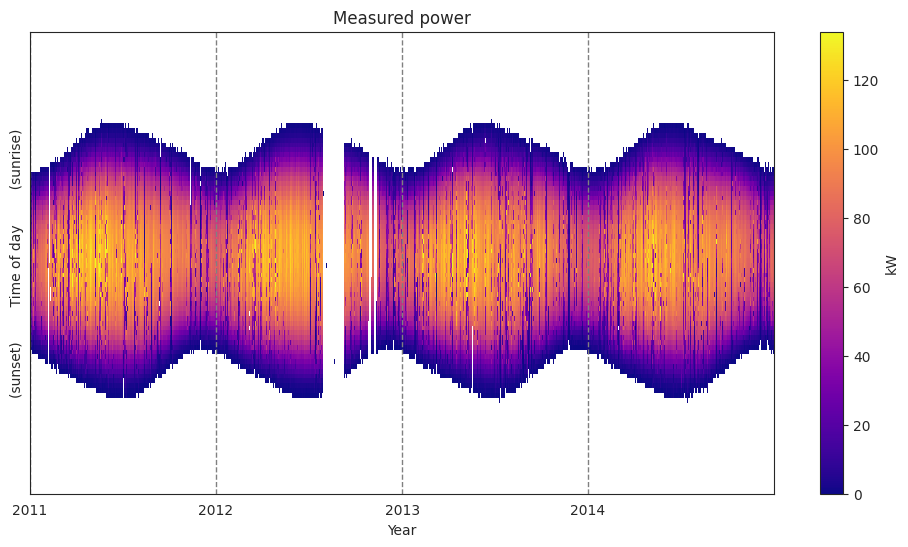

In [20]:
dh.plot_heatmap('raw');

estimated clear sky system response:

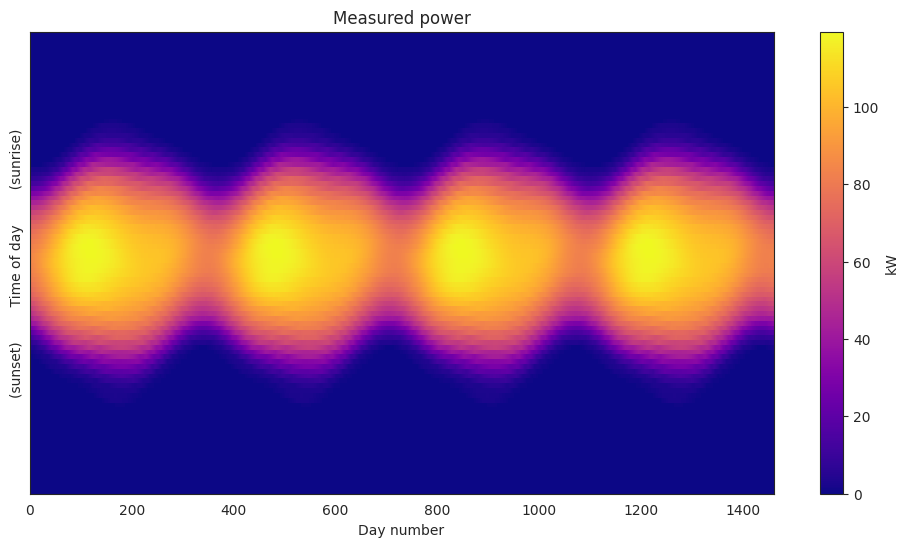

In [21]:
plot_2d(dh.scsf.reshape(dh.raw_data_matrix.shape, order='F')/1000);